In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import types as T
from pyspark.sql import functions as F
from pyspark.sql.window import Window
import os
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
spark = SparkSession.builder \
        .appName("Stock Prediction") \
        .master("local[*]") \
        .config("spark.ui.port", "8080") \
        .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/20 20:51:06 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
schema = T.StructType([
  T.StructField("datetime", T.DateType()),
  T.StructField("open", T.DoubleType()),
  T.StructField("high", T.DoubleType()),
  T.StructField("low", T.DoubleType()),
  T.StructField("close", T.DoubleType()),
  T.StructField("volume", T.DoubleType()),
  ])

In [4]:
df = spark.read \
    .format("csv") \
    .option("header", True) \
    .option("mode", "FAILFAST") \
    .schema(schema) \
    .load("../data/raw/archive/D1/*.csv")

In [5]:
@F.udf(returnType=T.StringType())
def get_basename(path):
  filename = os.path.basename(path)
  filename_without_ext = os.path.splitext(filename)[0]
  return filename_without_ext.split('.')[0]

df = df.withColumn("ticket_name", get_basename(F.input_file_name()))

In [ ]:
window_spec = Window.partitionBy(F.col("ticket_name")).orderBy(F.col("ticket_name"))

In [ ]:
df = df.withColumn("VMA", F.avg("volumne").over(window_spec.rowsBetween(-2, 0))) \
  .withColumn("vol_change", (F.col("volume") - F.lag("volume").over(window_spec)) / F.lag("volume").over(window_spec))

@F.udf(returnType=T.DoubleType())
def true_range(columns):
  return max(columns)
df = df.withColumn("TR", 
              true_range(
                F.col("high") - F.col("low"), 
                F.abs(F.col('high') - F.lag('close').over(window_spec)), 
                F.abs(F.col('low') - F.lag('close').over(window_spec))
                ))

DataFrame[datetime: date, open: double, high: double, low: double, close: double, volume: double, ticket_name: string, price_change: double, daily_return: double, log_return: double, TR: double]

In [39]:
df = df.withColumn("formatted_timestamp", F.to_timestamp("datetime", "MM/dd/yyyy hh:mm:ss")) \
  .withColumn("is_weekday", (F.dayofweek("datetime") >=2) & (F.dayofweek("datetime") <= 6)) \
  .drop("datetime")

In [8]:
df.printSchema()

root
 |-- datetime: date (nullable = true)
 |-- open: double (nullable = true)
 |-- high: double (nullable = true)
 |-- low: double (nullable = true)
 |-- close: double (nullable = true)
 |-- volume: double (nullable = true)



In [32]:
df_sample = df.filter(F.col('ticket_name') == 'AAPL').toPandas()

In [ ]:
df_sample.index = df_sample['datetime']
df_sample = df_sample.drop(columns='datetime', axis=1)

In [37]:
df_sample

,open,high,low,close,volume,ticket_name
datetime,,,,,,
1998-01-02,0.12,0.14,0.12,0.14,170539824.0,AAPL
1998-01-05,0.14,0.14,0.13,0.14,152723900.0,AAPL
1998-01-06,0.14,0.17,0.13,0.16,433041952.0,AAPL
1998-01-07,0.16,0.16,0.15,0.15,251914152.0,AAPL
1998-01-08,0.15,0.16,0.15,0.16,188994988.0,AAPL
...,...,...,...,...,...,...
2024-03-08,169.12,173.70,168.95,170.98,53335094.0,AAPL
2024-03-09,170.99,171.01,170.77,170.79,59796.0,AAPL
2024-03-11,172.94,174.38,172.05,172.75,44605588.0,AAPL


In [39]:
df_sample.dtypes

open           float64
high           float64
low            float64
close          float64
volume         float64
ticket_name     object
dtype: object

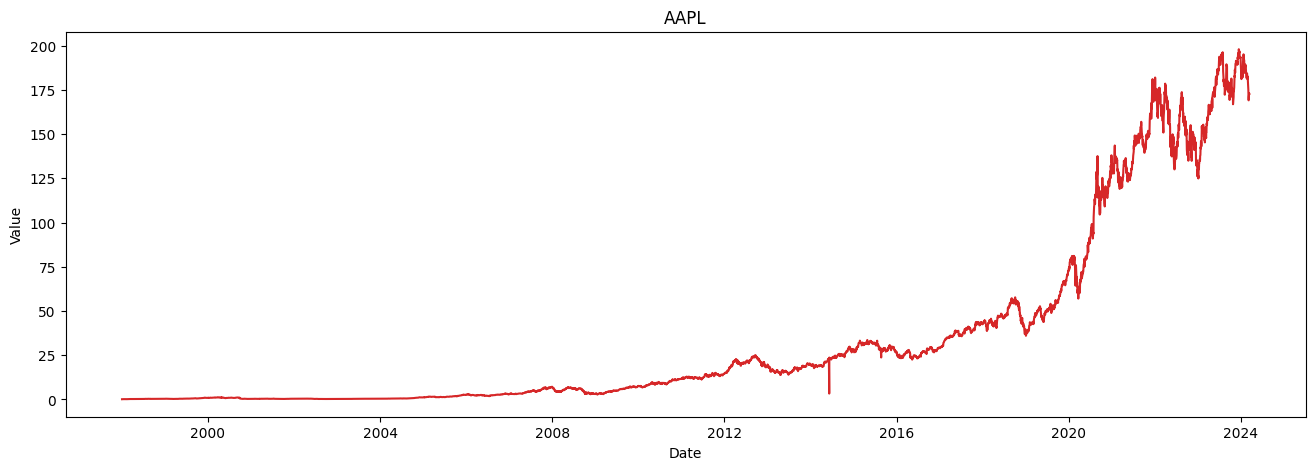

In [40]:
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
  plt.figure(figsize=(16,5), dpi=dpi)
  plt.plot(x, y, color='tab:red')
  plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
  plt.show()

plot_df(df_sample, x=df_sample.index, y=df_sample['open'], title='AAPL')

In [44]:
df_sample = df_sample.asfreq('D')
df_sample

,open,high,low,close,volume,ticket_name
datetime,,,,,,
1998-01-02,0.12,0.14,0.12,0.14,170539824.0,AAPL
1998-01-03,NaN,NaN,NaN,NaN,NaN,NaN
1998-01-04,NaN,NaN,NaN,NaN,NaN,NaN
1998-01-05,0.14,0.14,0.13,0.14,152723900.0,AAPL
1998-01-06,0.14,0.17,0.13,0.16,433041952.0,AAPL
...,...,...,...,...,...,...
2024-03-09,170.99,171.01,170.77,170.79,59796.0,AAPL
2024-03-10,NaN,NaN,NaN,NaN,NaN,NaN
2024-03-11,172.94,174.38,172.05,172.75,44605588.0,AAPL


In [45]:
df_sample.isna().sum()

open           2929
high           2929
low            2929
close          2929
volume         2929
ticket_name    2929
dtype: int64

In [ ]:
df_sample = df_sample.fillna(method='ffill')

/tmp/ipykernel_803573/182104173.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_sample = df_sample.fillna(method='ffill')


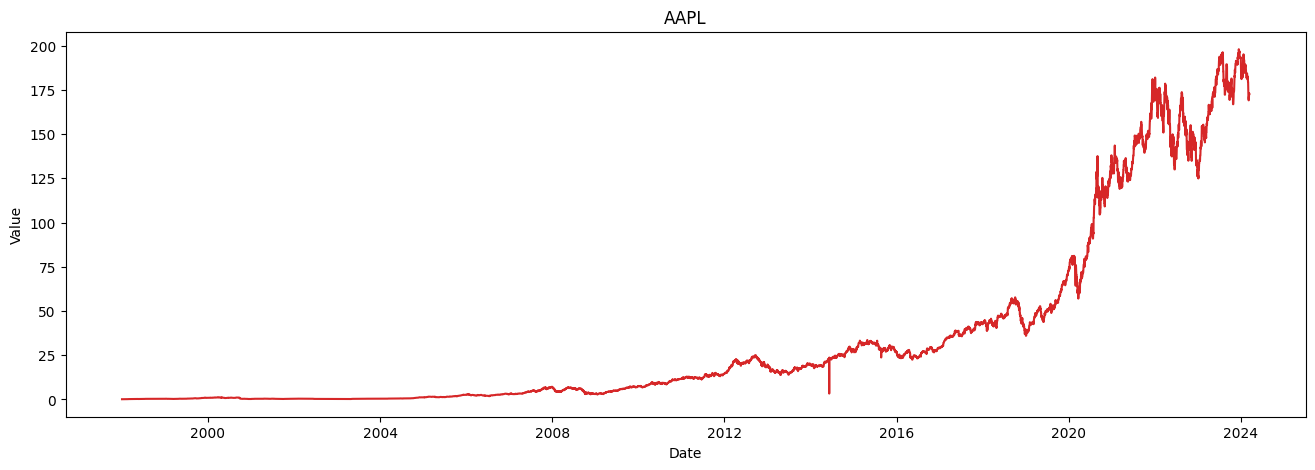

In [ ]:
plot_df(df_sample, x=df_sample.index, y=df_sample['open'], title='AAPL')

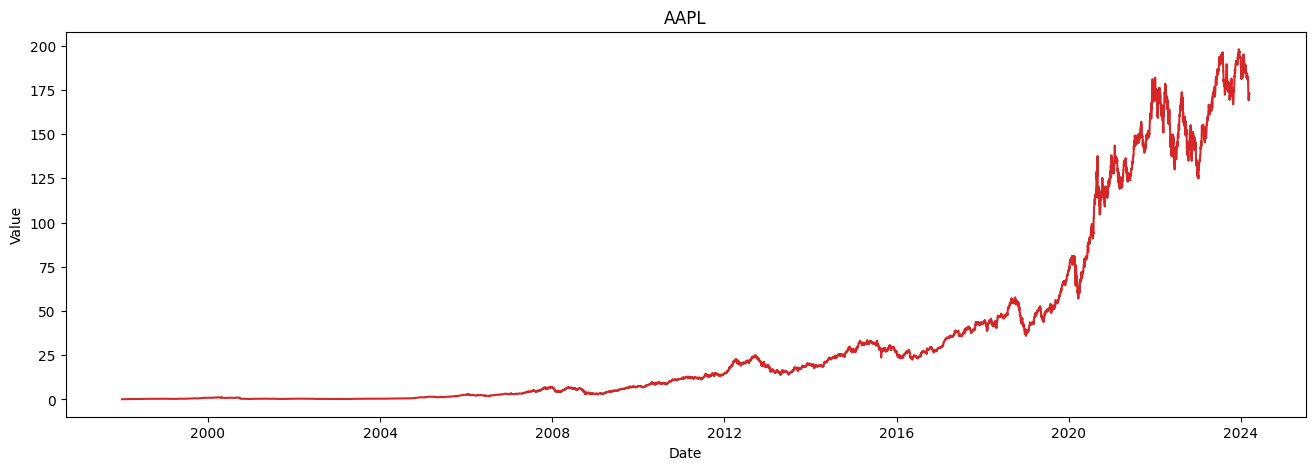

In [82]:
df_sample_cp = df_sample.drop(index = '2014-06-09')
plot_df(df_sample_cp, x=df_sample_cp.index, y=df_sample_cp['open'], title='AAPL')

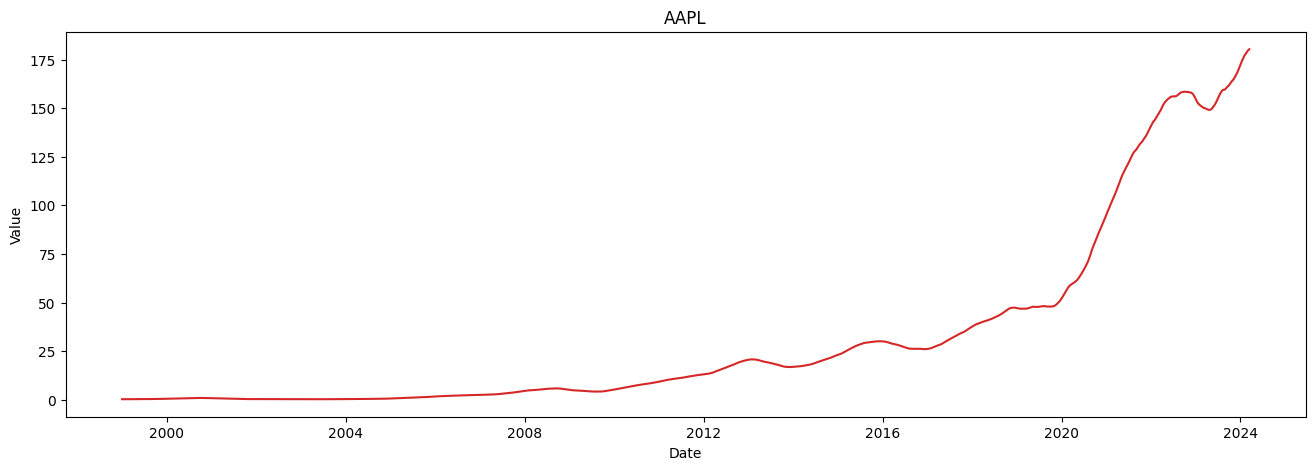

,open,high,low,close,volume,ticket_name,rolling_open_mean
datetime,,,,,,,
1998-01-02,0.12,0.14,0.12,0.14,170539824.0,AAPL,NaN
1998-01-03,0.12,0.14,0.12,0.14,170539824.0,AAPL,NaN
1998-01-04,0.12,0.14,0.12,0.14,170539824.0,AAPL,NaN
1998-01-05,0.14,0.14,0.13,0.14,152723900.0,AAPL,NaN
1998-01-06,0.14,0.17,0.13,0.16,433041952.0,AAPL,NaN
...,...,...,...,...,...,...,...
2024-03-09,170.99,171.01,170.77,170.79,59796.0,AAPL,180.042548
2024-03-10,170.99,171.01,170.77,170.79,59796.0,AAPL,180.103945
2024-03-11,172.94,174.38,172.05,172.75,44605588.0,AAPL,180.170685


In [87]:
df_sample_cp['rolling_open_mean'] = df_sample_cp['open'].rolling(window=365).mean()
plot_df(df_sample_cp, x=df_sample_cp.index, y=df_sample_cp['rolling_open_mean'], title='AAPL')
df_sample_cp

In [ ]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df_sample_cp['open'])

print('ADF Statistic:', result[0])
print('p-value:', result[1]) #p-value >= 0.05 <=> non-stationary series
print('Used lags:', result[2])
print('Number of observations:', result[3])

ADF Statistic: 1.1269216088226295
p-value: 0.9954399632769899
Used lags: 24
Number of observations: 9542
